In [482]:
!pip install xgboost

In [483]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [484]:
df = pd.read_csv('F:\Projects\Datasets\Energy Data\PJME_hourly.csv')

In [485]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [486]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [487]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [488]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [489]:
df.columns

Index(['PJME_MW'], dtype='object')

In [490]:
color_pal = sns.color_palette()

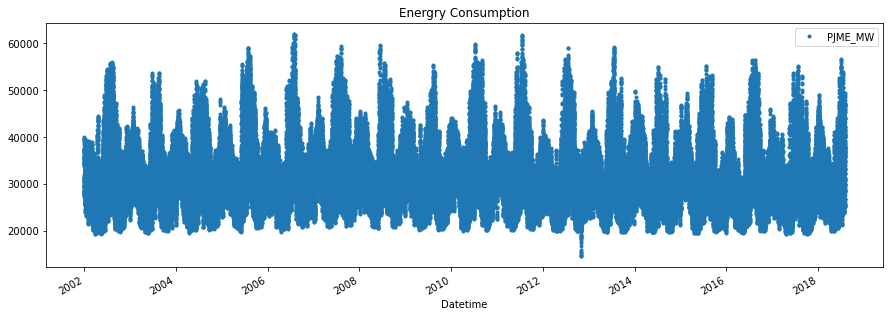

In [491]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Energry Consumption')
plt.show()

<AxesSubplot:ylabel='Frequency'>

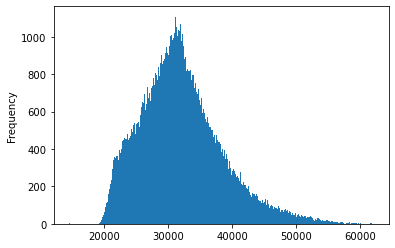

In [492]:
df['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot:xlabel='Datetime'>

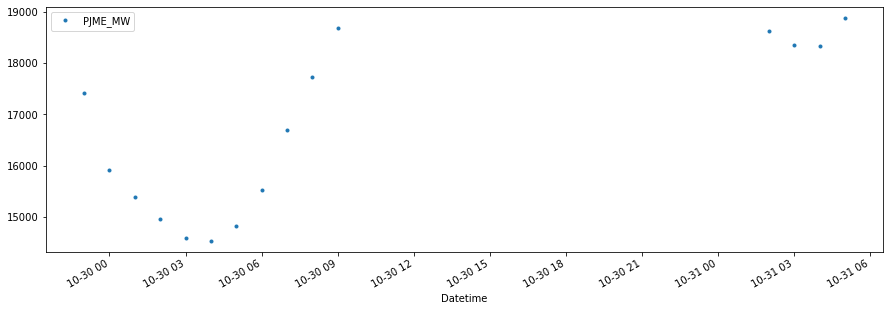

In [493]:
df.query('PJME_MW < 19000').plot(figsize=(15,5), style='.')

In [494]:
df = df.query('PJME_MW > 19000').copy()

In [495]:
#Train/Test Split

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

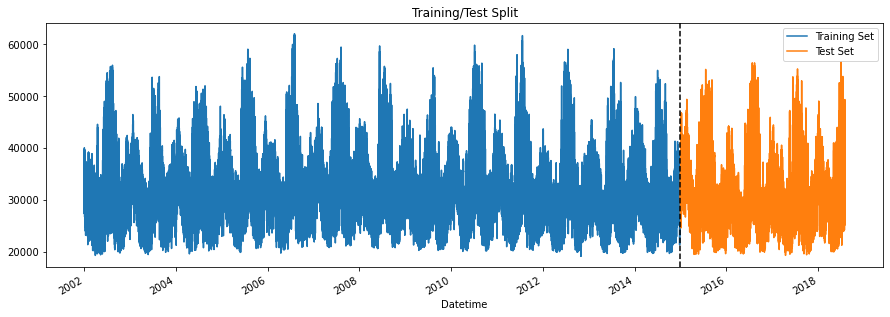

In [496]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Training/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [497]:
#Time Series Cross Validation

In [498]:
from sklearn.model_selection import TimeSeriesSplit

In [499]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

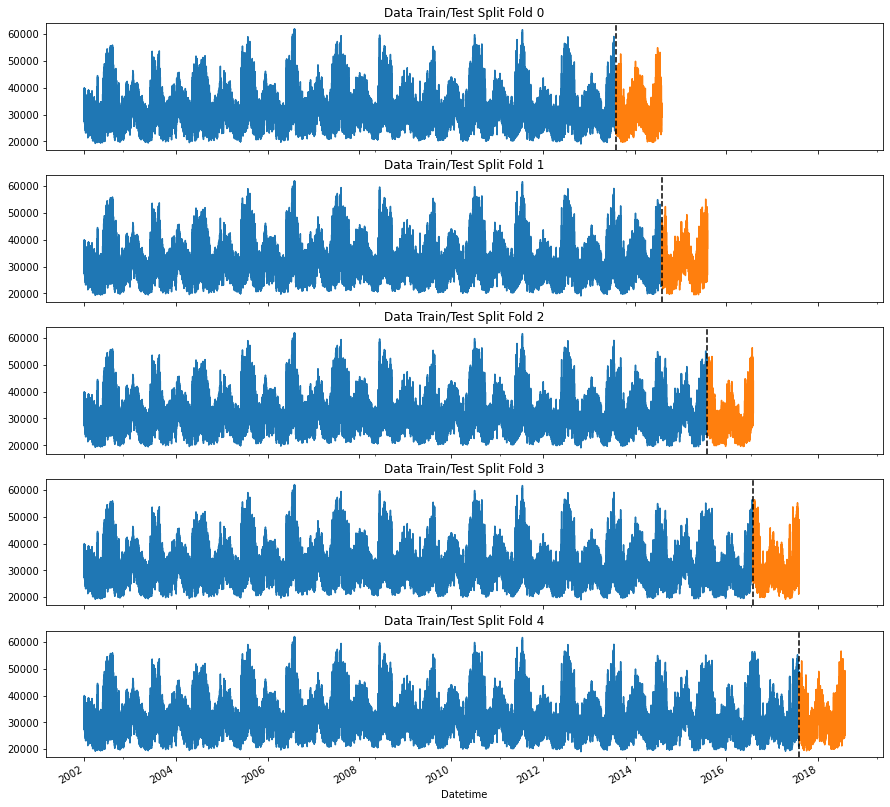

In [500]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [501]:
(df.index > '01-01-2010') & (df.index < '01-07-2010')

array([False, False, False, ..., False, False, False])

<AxesSubplot:title={'center':'Week of Data'}, xlabel='Datetime'>

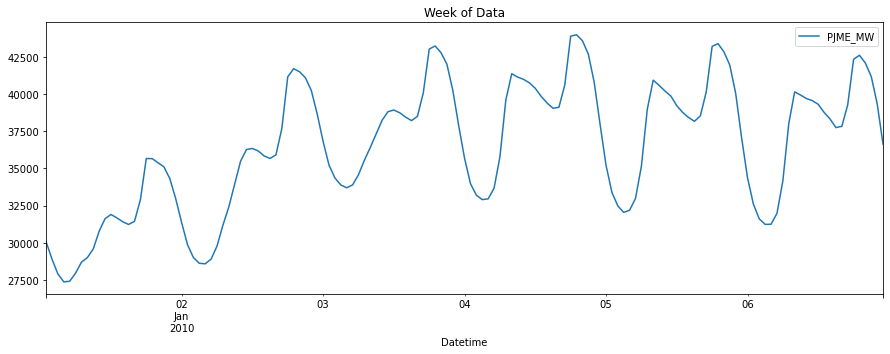

In [502]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-07-2010')].plot(figsize=(15,5), title='Week of Data')

In [503]:
#Feature Creation

In [504]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [505]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [506]:
df = add_lags(df)

In [507]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN


In [508]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    Feature_columns = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1','lag2','lag3'] 
    Target_column = ['PJME_MW']
    
    X_train = train[Feature_columns]
    y_train = train[Target_column]

    X_test = test[Feature_columns]
    y_test = test[Target_column]
    
    model = xgb.XGBRegressor(base_score=0.5, 
                             booster='gbtree',
                             n_estimators=1000,
                             early_stopping_rounds=50,
                             objective='reg:squarederror',
                             max_depth=3,
                             learning_rate=0.001)
    model.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
         verbose=100)
    
    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:33025.19344	validation_1-rmse:32246.90170
[100]	validation_0-rmse:29933.98017	validation_1-rmse:29176.58516
[200]	validation_0-rmse:27141.49979	validation_1-rmse:26397.10126
[300]	validation_0-rmse:24619.60567	validation_1-rmse:23892.48830
[400]	validation_0-rmse:22342.83724	validation_1-rmse:21633.82905
[500]	validation_0-rmse:20288.13716	validation_1-rmse:19598.21208
[600]	validation_0-rmse:18433.84441	validation_1-rmse:17751.46385
[700]	validation_0-rmse:16762.99361	validation_1-rmse:16093.16305
[800]	validation_0-rmse:15258.29377	validation_1-rmse:14600.97318
[900]	validation_0-rmse:13904.49934	validation_1-rmse:13261.51137
[999]	validation_0-rmse:12699.41284	validation_1-rmse:12071.82580
[0]	validation_0-rmse:32964.32774	validation_1-rmse:32428.90533
[100]	validation_0-rmse:29878.81866	validation_1-rmse:29374.44330
[200]	validation_0-rmse:27091.49331	validation_1-rmse:26616.82765
[300]	validation_0-rmse:24574.39294	validation_1-rmse:24127.91389
[400]	validati

In [509]:
print(f'Avg score across folds {np.mean(scores):0.2f}')
print(f'Fold scores: {scores}')

Avg score across folds 12011.56
Fold scores: [12071.825793990154, 12388.210724384866, 11300.634680178478, 12177.681621523401, 12119.457458570769]


In [510]:
#Retrain the model with all the data

In [511]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

model = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
model.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991
[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[500]	validation_0-rmse:3456.23244
[600]	validation_0-rmse:3401.28695
[700]	validation_0-rmse:3365.32547
[800]	validation_0-rmse:3334.20660
[900]	validation_0-rmse:3307.11413
[999]	validation_0-rmse:3284.26319


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [512]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [513]:
# Create future dataframe
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

In [514]:
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2019-07-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2019-07-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2019-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True


In [515]:
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [516]:
future_w_features = df_and_future.query('isFuture').copy()

In [517]:
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [535]:
# Predict the future

In [536]:
Feature_columns

['dayofyear',
 'hour',
 'dayofweek',
 'quarter',
 'month',
 'year',
 'lag1',
 'lag2',
 'lag3']

In [537]:
FEATURES

['dayofyear',
 'hour',
 'dayofweek',
 'quarter',
 'month',
 'year',
 'lag1',
 'lag2',
 'lag3']

In [540]:
future_w_features['pred'] = model.predict(future_w_features[FEATURES])

<AxesSubplot:title={'center':'Future Predictions'}>

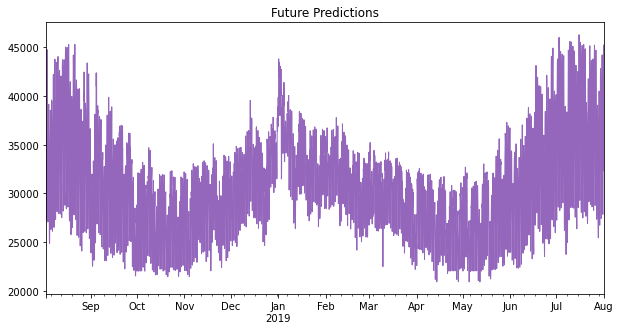

In [541]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')

In [542]:
#Visualise Feature/Target Relationship

Text(0.5, 1.0, 'MW by Hour')

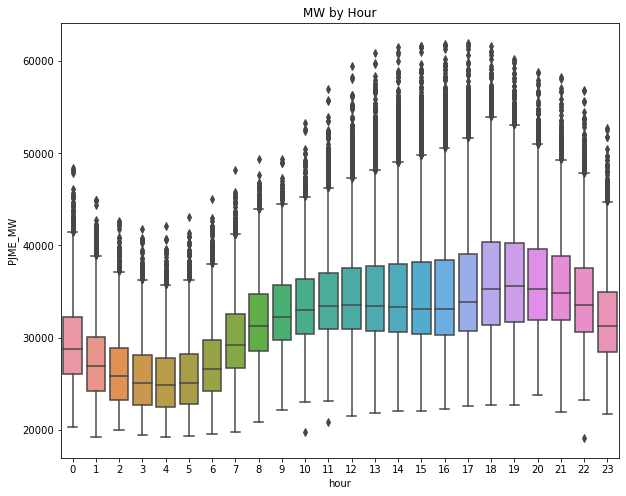

In [543]:
fig, ax= plt.subplots(figsize=(10,8)) 
sns.boxplot(data=df, x='hour', y = 'PJME_MW' )
ax.set_title('MW by Hour')

Text(0.5, 1.0, 'MW by Month')

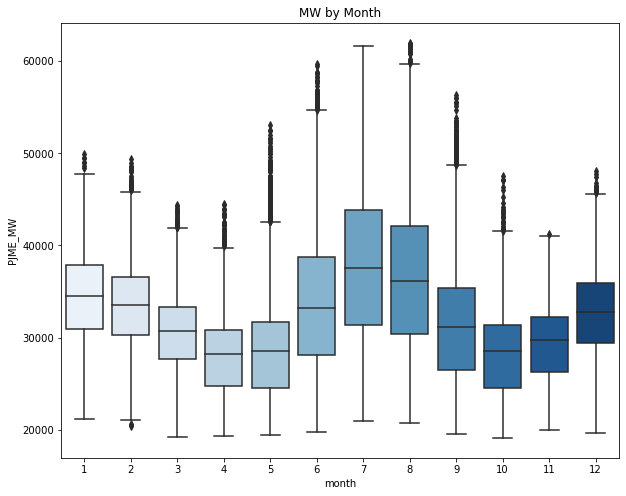

In [544]:
fig, ax= plt.subplots(figsize=(10,8)) 
sns.boxplot(data=df, x='month', y = 'PJME_MW', palette='Blues' )
ax.set_title('MW by Month')

In [545]:
#Create the Model

In [546]:
#Feature Importance

<AxesSubplot:title={'center':'Feature Importance'}>

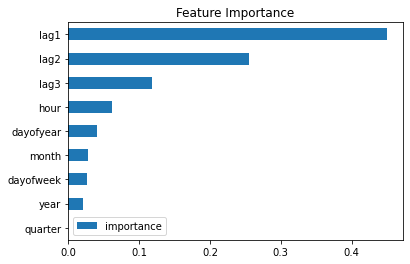

In [547]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
            columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

In [548]:
#Forecast on Test

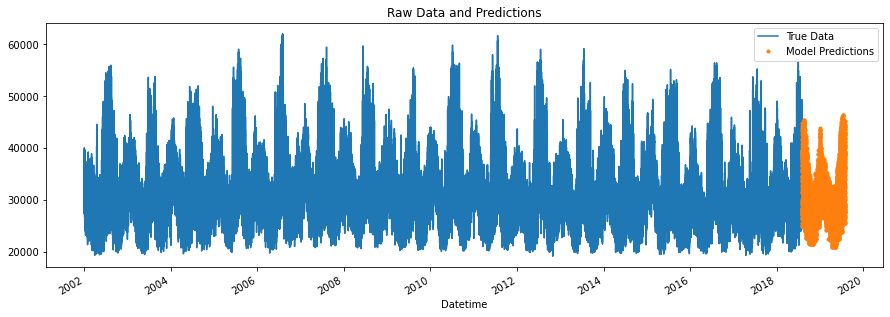

In [551]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
future_w_features['pred'].plot(ax=ax, style='.')
ax.set_title('Raw Data and Predictions')
plt.legend(['True Data', 'Model Predictions'])

<AxesSubplot:title={'center':'Week of Data'}, xlabel='Datetime'>

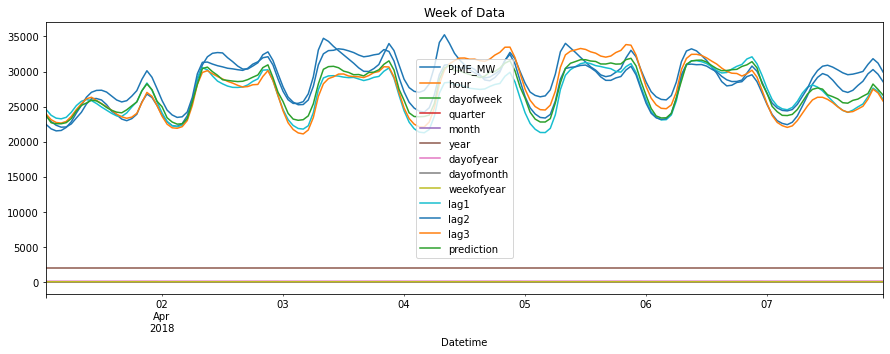

In [553]:
df.loc[(df.index > '04-01-2018') & 
       (df.index < '04-08-2018')].plot(figsize=(15,5), 
                                       title='Week of Data')